# 预测2018年俄罗斯世界杯

* 本讲座旨在利用历史国际A级赛事数据（去除友谊赛），运用机器学习对2018年俄罗斯世界杯进行预测和模拟，最后给出每场比赛的模拟结果以及冠军得主分布图
* Python language
* Ipython notebook内容流程如下所示：
    * Objective definition
    * Data collection, Exploratory Data Analysis
    * Data visualization, statistic summary, domain knowledge analysis
    * Feature engineering
    * Model building
    * Prediction for all possible games with 32 teams
    * Tournament simulation for 2018 world cup

In [0]:
# import useful python packages
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (12, 8)
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from collections import Counter
import operator
from itertools import combinations, permutations

# machine learning algorithms using sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

## Objective definition

* 我们想要预测，给定两支队伍，比赛的净胜球数是多少
* 净胜球的正负代表team1的赢输
* 预测目标是连续型变量，需要用regression的方法

## Read and preprocess data

* Data来自于GitHub https://github.com/neaorin/PredictTheWorldCup/tree/master/input
* 包含3w多场国际A级赛事，1956年至2017年
* 涵盖的联赛有世界杯，联合会杯，各大洲锦标赛，奥运会，国际友谊赛等

In [0]:
matches = pd.read_csv("./world_cup/matches.csv")
confederations = pd.read_csv("./world_cup/confederations.csv")

In [0]:
# raw data
matches.head(2)

,date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore
0,19560930,AUT,Austria,LUX,Luxembourg,7-0,NaN,"Ernst Happel Stadium - Vienna , Austria",10,FIFA World Cup™ Qualifier,7,0,NaN,NaN
1,19561003,IRL,Republic of Ireland,DEN,Denmark,2-1,NaN,"DUBLIN - Dublin , Republic of Ireland",10,FIFA World Cup™ Qualifier,2,1,NaN,NaN


In [0]:
# remove duplicates
matches = matches.drop_duplicates()
# extract datetime with yyyy-mm-dd format
matches['datetime'] = matches['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))
# 友谊赛去掉后剩17000
matches.shape

(33873, 15)

In [0]:
set(matches['CupName'].values)

{'Continental Final',
 'Continental Qualifier',
 'FIFA Confederations Cup',
 'FIFA World Cup\xe2\x84\xa2 Final',
 'FIFA World Cup\xe2\x84\xa2 Qualifier',
 'Friendly',
 'Olympic Football Tournament Final',
 'Olympic Football Tournament Quali 1908-1956',
 'Olympic Football Tournament Qualifier',
 'Olympic Football Tournament Qualifier &gt;1956'}

这里创建两个关于主场信息的dummy variables：isHome1, isHome2
* 如果是第一支队伍的主场，isHome1为True，isHome2为False，反之亦然
* 如果同城，则都为True；如果是第三方主场，则都为False

In [0]:
matches['isHome1'] = matches.apply(lambda x: str(x['team1Text']) in str(x['venue']), axis=1)
matches['isHome2'] = matches.apply(lambda x: str(x['team2Text']) in str(x['venue']), axis=1)
# 备份一个dataframe包含友谊赛
matches_friendly = matches.copy()
# 由于这里预测世界杯，所以将友谊赛去除
matches = matches[matches['CupName']!='Friendly']
# 为保证模型不受outlier干扰，去除单只队伍进球数在10球以上的数据
matches = matches[(matches['team1Score']<=10) & (matches['team2Score']<=10)]

FIFA的比赛大多数把胜利的队伍放在team1，导致两队比分差的均值为0.6>0，这样对后续模型预测有影响。所以我们将一场比赛team1和team2的信息对调，然后加入原数据集中

In [0]:
matches_reverse = matches.copy()
matches_reverse['team1'] = matches['team2']
matches_reverse['team1Text'] = matches['team2Text']
matches_reverse['team2'] = matches['team1']
matches_reverse['team2Text'] = matches['team1Text']
matches_reverse['resText'] = matches['resText'].apply(lambda x: x.split('-')[1]+'-'+x.split('-')[0])
matches_reverse['team1Score'] = matches['team2Score']
matches_reverse['team2Score'] = matches['team1Score']
matches_reverse['isHome1'] = matches['isHome2']
matches_reverse['isHome2'] = matches['isHome1']
matches = pd.concat([matches, matches_reverse])

In [0]:
matches.index = range(len(matches))
matches.sort_values(by='date').head(4)

,date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore,datetime,isHome1,isHome2
13056,19500308,WAL,Wales,NIR,Northern Ireland,0-0,NaN,"CARDIFF - Cardiff , Wales",6,FIFA World Cup™ Qualifier,0,0,NaN,NaN,1950-03-08,True,False
30044,19500308,NIR,Northern Ireland,WAL,Wales,0-0,NaN,"CARDIFF - Cardiff , Wales",6,FIFA World Cup™ Qualifier,0,0,NaN,NaN,1950-03-08,False,True
30045,19500402,POR,Portugal,ESP,Spain,1-5,NaN,"MADRID - Madrid , Spain",6,FIFA World Cup™ Qualifier,1,5,NaN,NaN,1950-04-02,False,True
13057,19500402,ESP,Spain,POR,Portugal,5-1,NaN,"MADRID - Madrid , Spain",6,FIFA World Cup™ Qualifier,5,1,NaN,NaN,1950-04-02,True,False


## Statistical analysis & domain knowledge

### 比赛年份 vs 每场平均进球数

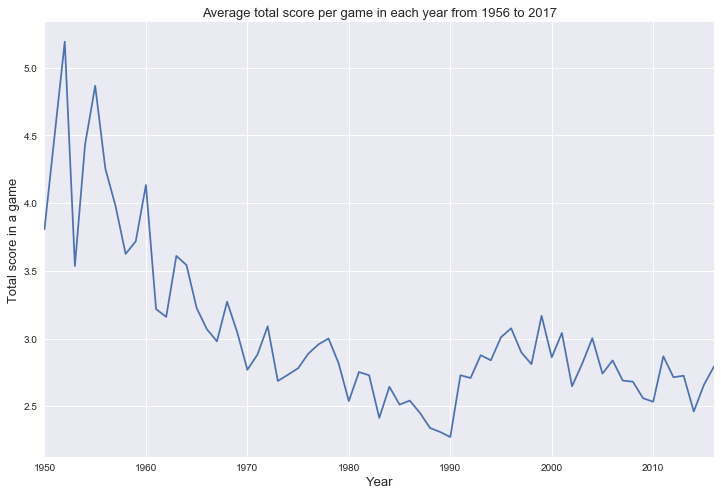

In [0]:
# extract year and total score variables
matches['year'] = matches['datetime'].apply(lambda x: x[:4])
matches['totalScore'] = matches['team1Score'] + matches['team2Score']
# plot trend of total score with the change of year
year_score = matches.groupby('year').mean().reset_index()[['year','totalScore']]
year_score['subject'] = 0
ax = sns.tsplot(data=year_score, time='year', value='totalScore', unit='subject')
ax.set_title("Average total score per game in each year from 1956 to 2017", fontsize=13)
ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Total score in a game", fontsize=13)
plt.show()

### 球队胜率 vs 比赛场次（含友谊赛和不含友谊赛对比）

In [0]:
# create a dictionary to store number of total games and number of winning games for each team
def win_percentage(matches):
    team_info = {}
    for i in matches.index:
        t1 = matches.loc[i,'team1']
        t2 = matches.loc[i,'team2']
        s1 = matches.loc[i,'team1Score']
        s2 = matches.loc[i,'team2Score']
        # check for team 1
        if t1 in team_info:
            team_info[t1][0] += 1
            if s1 > s2:
                team_info[t1][1] += 1
        else:
            if s1 > s2:
                team_info[t1] = [1,1]
            else:
                team_info[t1] = [1,0]
        # the same for team 2
        if t2 in team_info:
            team_info[t2][0] += 1
            if s2 > s1:
                team_info[t2][1] += 1
        else:
            if s2 > s1:
                team_info[t2] = [1,1]
            else:
                team_info[t2] = [1,0]

    # convert to dataframe
    team_df = pd.DataFrame(team_info).T
    team_df.columns = ['numOfTotal','numOfWin']
    team_df['teamName'] = team_df.index
    team_df['winningPercentage'] = team_df['numOfWin'] / (team_df['numOfTotal'] + 0.0)
    # remove teams that have total games less than 10
    team_df = team_df[team_df['numOfTotal']>=10]
    return team_df

# winning percentage without friendly game
team_df_no_friendly = win_percentage(matches)
# winning percentage with friendly game
team_df_friendly = win_percentage(matches_friendly)

In [0]:
team_df_no_friendly.head()

,numOfTotal,numOfWin,teamName,winningPercentage
AFG,76,14,AFG,0.184211
AIA,50,2,AIA,0.040000
ALB,400,62,ALB,0.155000
ALG,498,218,ALG,0.437751
AND,182,2,AND,0.010989


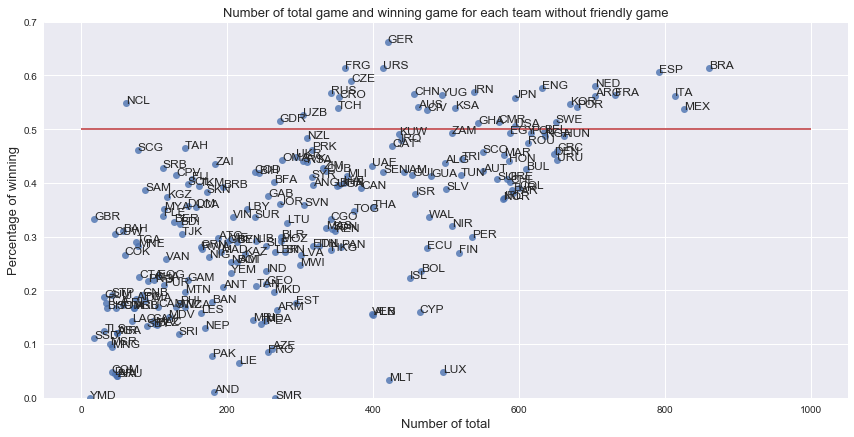

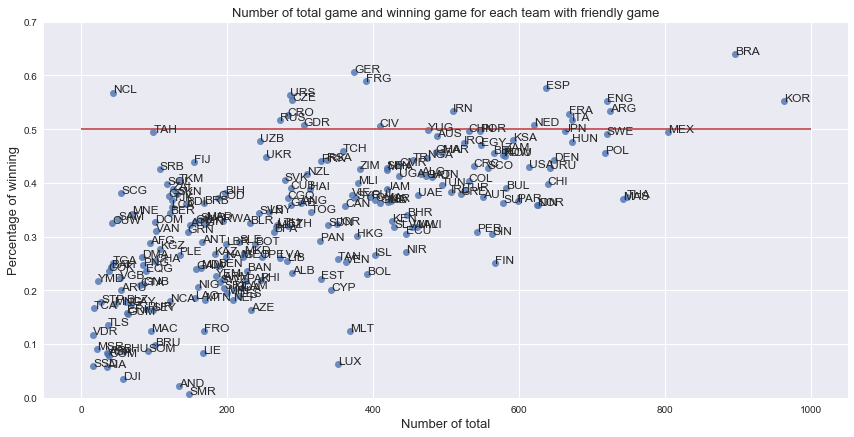

In [0]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

def visualize_winning_percentage(df, title, n):
    ax = sns.lmplot('numOfTotal', 'winningPercentage', data=df, fit_reg=False, size = 6, aspect = 2) 
    label_point(df.numOfTotal, df.winningPercentage, 
                df.teamName, plt.gca())
    plt.hlines(0.5,0,n,colors='r')
    plt.title("Number of total game and winning game for each team "+title, fontsize=13)
    plt.xlabel("Number of total", fontsize=13)
    plt.ylabel("Percentage of winning", fontsize=13)
    plt.ylim(0,0.7)
    plt.show()

visualize_winning_percentage(team_df_no_friendly, 'without friendly game', 1000)
visualize_winning_percentage(team_df_friendly, 'with friendly game', 1000)

* CHN接近0.57，比韩国日本都高
* 韩国队友谊赛场次很多
* GER比赛次数较少的原因：FRG西德 & GDR东德
* 巴西无论友谊赛还是正式联赛，场次都非常多
* 比较删除友谊赛之前和之后的数据，德国在友谊赛中胜率不高，但是正规赛特别高；巴西反之

### 比分统计

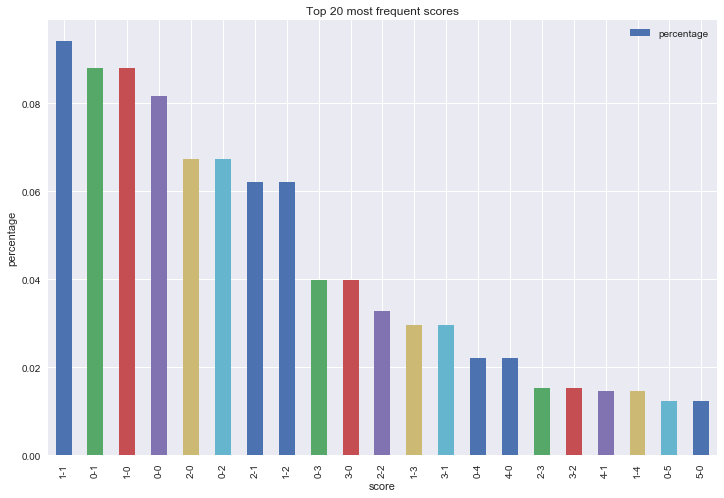

In [0]:
matches['scoreText'] = [str(x)+'-'+str(y) for x,y in zip(matches['team1Score'], matches['team2Score'])]

# most frequent score
score_dict = dict(Counter(matches['scoreText']))
score_df = pd.DataFrame(sorted(score_dict.items(), key=operator.itemgetter(1), reverse = True))
score_df.columns = ['score','frequency']
score_df['percentage'] = score_df['frequency'] / (sum(score_df['frequency']) + 0.0)
score_df.loc[:20,:].plot.bar('score','percentage')
plt.ylabel("percentage")
plt.title("Top 20 most frequent scores")
plt.show()

### 进球数统计

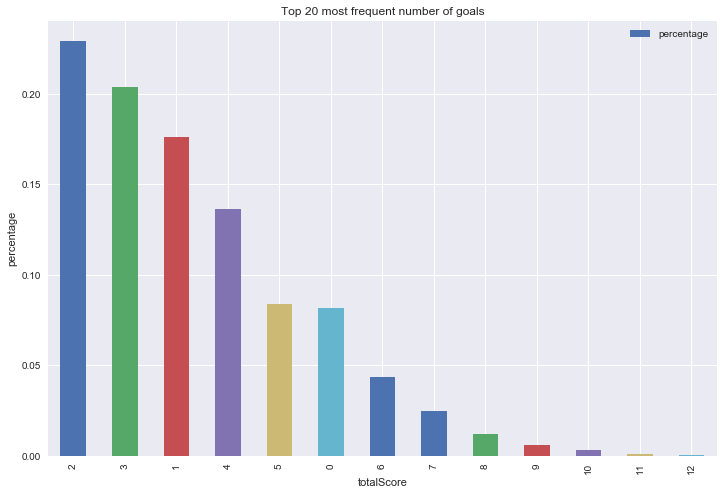

In [0]:
# most frequent number of goals
goal_dict = dict(Counter(matches['totalScore']))
goal_df = pd.DataFrame(sorted(goal_dict.items(), key=operator.itemgetter(1), reverse = True))
goal_df.columns = ['totalScore','frequency']
goal_df['percentage'] = goal_df['frequency'] / (sum(goal_df['frequency']) + 0.0)
goal_df.plot.bar('totalScore','percentage')
plt.ylabel("percentage")
plt.title("Top 20 most frequent number of goals")
plt.show()

### 分差统计

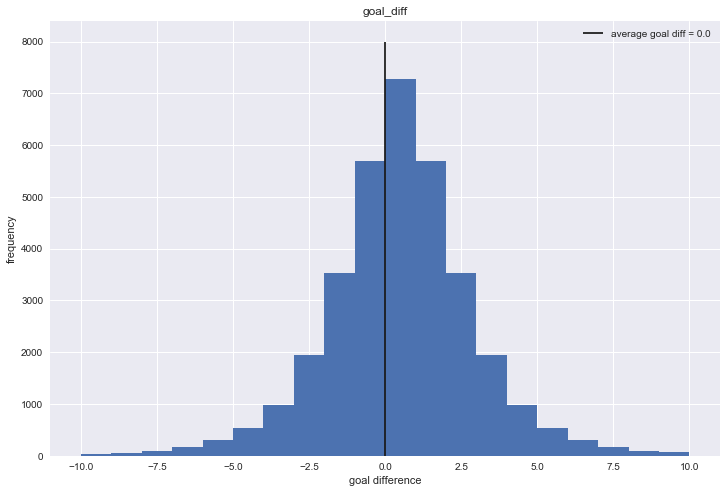

In [0]:
# goal difference histogram
matches['goal_diff'] = matches['team1Score'] - matches['team2Score']
matches.hist('goal_diff',bins=20)
avg_goal_diff = matches['goal_diff'].mean()
# 加一个standard deviation
plt.vlines(avg_goal_diff,0,8000,label="average goal diff = "+str(round(avg_goal_diff,3)))
plt.legend()
plt.xlabel("goal difference")
plt.ylabel("frequency")
plt.show()

### 检验正态性

In [0]:
from scipy.stats import kstest, normaltest, anderson
x = matches['goal_diff']
y = (x-np.mean(x)) / np.std(x)

# Kolmogorov-Smirnov
# Shapiro Wilk test
ks_results = kstest(y, cdf='norm')
print 'K-S test: ', ks_results

# normaltest
nt_results = normaltest(y)
print 'Normaltest: ', nt_results

# anderson
print 'Anderson test:', anderson(y)

K-S test:  KstestResult(statistic=0.11427415553444686, pvalue=0.0)
Normaltest:  NormaltestResult(statistic=1179.6726644249293, pvalue=6.875997246056004e-257)
Anderson test: AndersonResult(statistic=413.7284545665025, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


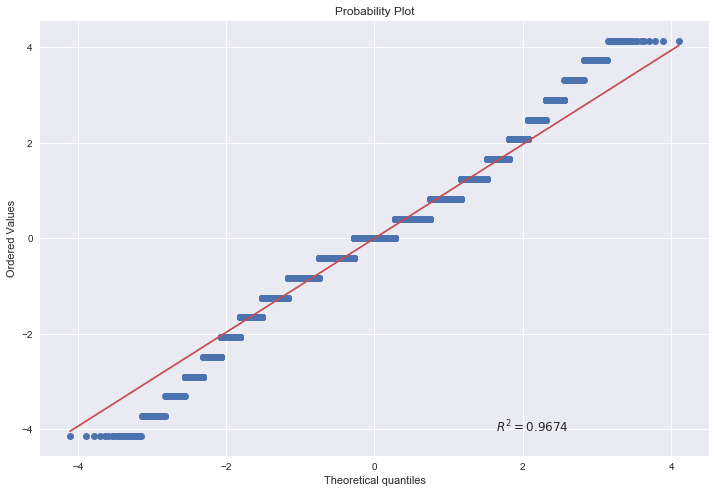

In [0]:
# Q-Q plot
import scipy.stats as stats
import pylab
stats.probplot(y, dist="norm", plot=pylab, rvalue=True)
pylab.show()

### 主场胜率分析


分析球队主场胜率比所有比赛胜率高出多少？挑选top10和last10

In [0]:
home_team = list(set(matches['team1']))
home_team_res = []

# first create win/loss/draw indicator variables
matches['win'] = matches['team1Score'] > matches['team2Score']
matches['loss'] = matches['team1Score'] < matches['team2Score']
matches['draw'] = matches['team1Score'] == matches['team2Score']

for t in home_team:
    tmp1 = matches[(matches['team1']==t)]
    home_tmp1 = matches[((matches['team1']==t) & (matches['isHome1']==True))]
    win =  (tmp1['win'].sum()) / (len(tmp1) + 0.0)
    loss = (tmp1['loss'].sum()) / (len(tmp1) + 0.0)
    draw = (tmp1['draw'].sum()) / (len(tmp1) + 0.0)
    home_win =  (home_tmp1['win'].sum()) / (len(home_tmp1) + 0.0)
    home_loss = (home_tmp1['loss'].sum()) / (len(home_tmp1) + 0.0)
    home_draw = (home_tmp1['draw'].sum()) / (len(home_tmp1) + 0.0)
    if len(tmp1) < 100 or win < 0.5:
        continue
#     print tmp1['win'].sum(), home_tmp1['win'].sum()
    home_team_res.append((t,win,loss,draw,home_win,home_loss,home_draw))
    
home_team_df = pd.DataFrame(home_team_res,columns=['team','win','loss','draw',
                                                   'home_win','home_loss','home_draw'])
home_team_df['home_increase'] = (home_team_df['home_win'] - home_team_df['win']) / home_team_df['win']

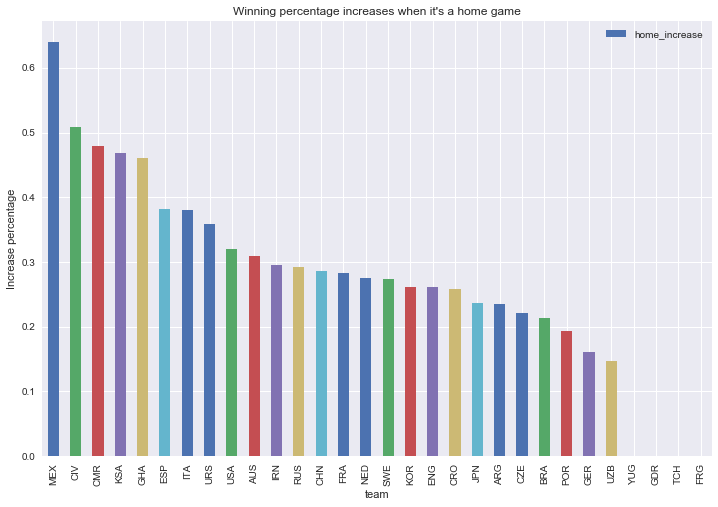

In [0]:
home_top_10 = home_team_df.sort_values(by='home_increase',ascending=False)
home_top_10.plot.bar(x='team',y='home_increase')
plt.ylabel("Increase percentage")
plt.title("Winning percentage increases when it's a home game")
plt.show()

* MEX:墨西哥
    * 球迷很给力
* CIV:科特迪瓦，CMR:喀麦隆，GHA:加纳
    * 西非国家，天气炎热，环境较恶劣

* YUG: 南斯拉夫国家足球队 1920-2006
    * 南斯拉夫国家足球队，是1920年至1992年间代表南斯拉夫的足球队，其名称在不同时期根据国家名称而变化，分别为：塞尔维亚人、克罗地亚人和斯洛文尼亚人王国（1920-1929年）、南斯拉夫王国（1929-1941年）、南斯拉夫联邦人民共和国（1946-1963年）、南斯拉夫社会主义联邦共和国（1963-1992年）。1992年至2002年间代表南斯拉夫的是南斯拉夫联盟国家足球队，2003年更名为塞尔维亚和黑山国家足球队，2006年黑山宣佈獨立後，改为塞尔维亚国家足球队。(https://zh.wikipedia.org/wiki/%E5%8D%97%E6%96%AF%E6%8B%89%E5%A4%AB%E5%9B%BD%E5%AE%B6%E8%B6%B3%E7%90%83%E9%98%9F)
* GDR: 东德 1949-1990
    * 德意志民主共和國國家足球隊，是德意志民主共和國的國家足球隊。由於東西德重新統一，在1990年結束。(https://zh.wikipedia.org/wiki/%E6%B0%91%E4%B8%BB%E5%BE%B7%E5%9B%BD%E5%9B%BD%E5%AE%B6%E8%B6%B3%E7%90%83%E9%98%9F)
* TCH: 捷克斯洛伐克 1922-1993 
    * 捷克斯洛伐克國家足球隊是捷克斯洛伐克1922年至1993年的国家足球队，獲得1934和1962年世界杯亞軍和1976年歐洲杯冠軍。冷戰結束後，捷克斯洛伐克在1993年分离为捷克和斯洛伐克，分离後國家足球隊也宣告分家。(https://zh.wikipedia.org/wiki/%E6%8D%B7%E5%85%8B%E6%96%AF%E6%B4%9B%E4%BC%90%E5%85%8B%E5%9C%8B%E5%AE%B6%E8%B6%B3%E7%90%83%E9%9A%8A)
* FRG: 西德 
    * 德国国家足球队的前身,胸前四颗星有三颗来自西德，分别是1954年、1974年、1990年(https://zh.wikipedia.org/wiki/%E5%BE%B7%E5%9C%8B%E5%9C%8B%E5%AE%B6%E8%B6%B3%E7%90%83%E9%9A%8A)

### Feature Engineering

将队伍的联赛强度加入数据集，这里分为自身强度和对手强度
* 强度范围为[0,1]，0表示联赛最弱，1代表联赛最强
* 欧洲联赛0.99，南美洲联赛1.0，其余0.85
* 没有匹配到的比赛是世界杯、联合会杯、奥运会等，以默认值1.0进行填充

confederation strength
https://en.wikipedia.org/wiki/FIFA_World_Rankings#Regional_strength

In [0]:
confederation_strength = pd.DataFrame([('AFC',0.85), 
                                       ('CAF',0.85), 
                                       ('CONCACAF',0.85), 
                                       ('CONMEBOL',1.0), 
                                       ('OFC',0.85), 
                                       ('UEFA',0.99)], columns=['name','strength'])
team_strength = confederations.merge(confederation_strength, how='left', 
                                     left_on='confederation', right_on='name')[['fifa_code','strength']]
team_strength.head()

,fifa_code,strength
0,ALG,0.85
1,ANG,0.85
2,BEN,0.85
3,BOT,0.85
4,BFA,0.85


In [0]:
# join confederation information
# model the strength of opposition faced
matches = matches.merge(team_strength, how='left', 
                        left_on='team2', right_on='fifa_code')

# model the strength of self faced
matches = matches.merge(team_strength, how='left', 
                        left_on='team1', right_on='fifa_code')

matches = matches.rename(columns = {'fifa_code_x':'oppo_team', 'strength_x':'oppo_strength',
                          'fifa_code_y':'self_team', 'strength_y':'self_strength'})

In [0]:
matches.head(2)

,date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore,datetime,isHome1,isHome2,year,totalScore,scoreText,goal_diff,win,loss,draw,oppo_team,oppo_strength,self_team,self_strength
0,19560930,AUT,Austria,LUX,Luxembourg,7-0,NaN,"Ernst Happel Stadium - Vienna , Austria",10,FIFA World Cup™ Qualifier,7,0,NaN,NaN,1956-09-30,True,False,1956,7,7-0,7,True,False,False,LUX,0.99,AUT,0.99
1,19561003,IRL,Republic of Ireland,DEN,Denmark,2-1,NaN,"DUBLIN - Dublin , Republic of Ireland",10,FIFA World Cup™ Qualifier,2,1,NaN,NaN,1956-10-03,True,False,1956,3,2-1,1,True,False,False,DEN,0.99,IRL,0.99


In [0]:
# fill nan with 1 in oppo_strength and self_strength columns
matches['oppo_strength'].fillna(1, inplace=True)
matches['self_strength'].fillna(1, inplace=True)

生成主要特征
* 过去10、30、50场比赛team1、team2的赢球比例、输球比例、平局比例、净胜球均值、对手所在联赛强度均值
* 特征数量有$3\times2\times5=30$
* team1和team2互为对手
* 计算特征时，先计算team1的信息，然后将得到的数据left join到原表中，如果以team1的名字join，则为team1的信息，如果以team2的名字join，则为team2的信息

In [0]:
# function to create variables for team1
def add_t1_info(df, width_list):
    df.index = range(len(df))
    for width in width_list:
        for i in range(len(df)):
            start = max(0,i-width+1)
            # calculate percentages
            l = max(i-start,0.001)
            df.loc[i,'win_per_'+str(width)+'_t1'] = sum(df['win'][start:i]) / (l + 0.0)
            df.loc[i,'loss_per_'+str(width)+'_t1'] = sum(df['loss'][start:i]) / (l + 0.0)
            df.loc[i,'draw_per_'+str(width)+'_t1'] = sum(df['draw'][start:i]) / (l + 0.0)
            df.loc[i,'goal_diff_per_'+str(width)+'_t1'] = sum(df['goal_diff'][start:i]) / (l + 0.0)
            df.loc[i,'oppo_strength_per_'+str(width)+'_t1'] = sum(df['oppo_strength'][start:i]) / (l + 0.0)
    return df


# # function to create variables for team2
# def add_t2_info(df, width_list):
#     df.index = range(len(df))
#     for width in width_list:
#         for i in range(len(df)):
#             start = max(0,i-width+1)
#             # calculate percentages
#             df.loc[i,'win_per_'+str(width)+'_t2'] = sum(df['loss'][start:i]) / (width + 0.0)
#             df.loc[i,'loss_per_'+str(width)+'_t2'] = sum(df['win'][start:i]) / (width + 0.0)
#             df.loc[i,'draw_per_'+str(width)+'_t2'] = sum(df['draw'][start:i]) / (width + 0.0)
#             df.loc[i,'goal_diff_per_'+str(width)+'_t2'] = -sum(df['goal_diff'][start:i]) / (width + 0.0)
#             df.loc[i,'oppo_strength_per_'+str(width)+'_t2'] = sum(df['self_strength'][start:i]) / (width + 0.0)
#     return df


# # test for add_t1_info function
# test_team = matches['team1'][0]
# test_df = matches[matches['team1']==team].sort_values(by='date')
# test = add_t1_info(test_df, [10,30])
# test.head()

# # test for add_t2_info function
# test_team = matches['team2'][0]
# test_df = matches[matches['team2']==team].sort_values(by='date')
# test = add_t2_info(test_df, [10,30])
# test.head()

In [0]:
team_list = list(set(matches['team1']))

print 'start adding team 1 variables'
# add team 1 information
matches_1 = pd.DataFrame()
# print new_matches.empty
for team in team_list:
    print team
    # filter out one single team and sort by date
    team1_df = matches[matches['team1']==team].sort_values(by='date')
    # add new variables
    tmp_df = add_t1_info(team1_df, [20,30,40])
    # concate to new_matches dataframe
    if matches_1.empty:
        matches_1 = tmp_df
    else:
        matches_1 = pd.concat([matches_1, tmp_df])

# print 'start adding team 2 variables'
# # add team 2 information
# matches_2 = pd.DataFrame()
# for team in team_list:
#     print team
#     # filter out one single team and sort by date
#     team2_df = matches_1[matches_1['team2']==team].sort_values(by='date')
#     # add new variables
#     tmp_df = add_t2_info(team2_df, [10,30,50])
#     # concate to new_matches dataframe
#     if matches_2.empty:
#         matches_2 = tmp_df
#     else:
#         matches_2 = pd.concat([matches_2, tmp_df])

# run 5 mins

start adding team 1 variables
QAT
EGY
LIB
LIE
SOM
BOT
PAR
MRI
NAM
DJI
BOL
GHA
PAK
SIN
YUG
JOR
LBR
SAM
LBY
SAA
GAM
PRK
KUW
EQG
MYA
TAN
UAE
HKG
SVN
HAI
TPE
VAN
BUL
CHI
CPV
GDR
CHN
URU
JAM
PER
URS
FIJ
ZIM
FIN
THA
MAS
MAR
YEM
VIE
ZAI
VIN
NIG
MNE
VIR
SYR
MAC
MAD
NIR
KAZ
COK
TCA
BRU
COD
CUW
DMA
GUA
BEN
NGA
BEL
MSR
GUI
GUM
CRC
KSA
DEN
BER
MWI
SKN
CMR
GER
SCO
HUN
TKM
PAN
TCH
GEO
ROU
MNG
TRI
MTQ
ENG
AFG
BDI
VGB
BLR
LVA
GRE
RUS
GRN
AND
MOZ
ANG
TJK
BRB
ANT
PUR
LCA
IND
MTN
GUY
NOR
CZE
ATG
MLT
DOM
LUX
ISR
NED
SMR
SUI
IDN
SUR
ISL
ETH
COM
COL
NEP
PHI
CGO
SCG
MDA
STP
ASA
SEY
ECU
SEN
MDV
SRB
FRA
WAL
FRG
LTU
RWA
SRI
FRO
AZE
AUS
AUT
VEN
KEN
OMA
LAO
ZAM
ALG
TUR
ALB
TUV
ITA
PLE
LES
TUN
GBR
MEX
BRA
CIV
TLS
CAY
MKD
CTA
USA
CHA
SWE
BFA
TAH
GNB
SWZ
CAN
CAM
BAN
KOR
AIA
TOG
BAH
SVK
CYP
BIH
POR
SOL
UZB
CRO
POL
TGA
ERI
GAB
EST
ESP
HON
IRQ
SLV
MLI
YMD
UKR
IRL
IRN
SSD
SLE
BLZ
NZL
ARU
JPN
KGZ
RSA
ARM
NCL
ARG
NCA
SDN
BHR
BHU
UGA
PNG
CUB


In [0]:
matches_feature = matches_1[['date','team1']+list(matches_1.columns[28:])]
matches_tmp = pd.merge(matches, matches_feature, how='left', left_on=['date','team1'], right_on=['date','team1'])

In [0]:
new_columns = []
for col in matches_feature.columns:
    tmp = col
    if '_t1' in tmp:
        tmp = tmp.replace('_t1','_t2')
    new_columns.append(tmp)
matches_feature.columns = new_columns
matches_2 = pd.merge(matches_tmp, matches_feature, how='left', left_on=['date','team2'], right_on=['date','team1'])
matches_2 = matches_2.rename(columns={'team1_x':'team1'})

In [0]:
matches_2.head(10)

,date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore,datetime,isHome1,isHome2,year,totalScore,scoreText,goal_diff,win,loss,draw,oppo_team,oppo_strength,self_team,self_strength,win_per_20_t1,loss_per_20_t1,draw_per_20_t1,goal_diff_per_20_t1,oppo_strength_per_20_t1,win_per_30_t1,loss_per_30_t1,draw_per_30_t1,goal_diff_per_30_t1,oppo_strength_per_30_t1,win_per_40_t1,loss_per_40_t1,draw_per_40_t1,goal_diff_per_40_t1,oppo_strength_per_40_t1,team1_y,win_per_20_t2,loss_per_20_t2,draw_per_20_t2,goal_diff_per_20_t2,oppo_strength_per_20_t2,win_per_30_t2,loss_per_30_t2,draw_per_30_t2,goal_diff_per_30_t2,oppo_strength_per_30_t2,win_per_40_t2,loss_per_40_t2,draw_per_40_t2,goal_diff_per_40_t2,oppo_strength_per_40_t2
0,19560930,AUT,Austria,LUX,Luxembourg,7-0,NaN,"Ernst Happel Stadium - Vienna , Austria",10,FIFA World Cup™ Qualifier,7,0,NaN,NaN,1956-09-30,True,False,1956,7,7-0,7,True,False,False,LUX,0.99,AUT,0.99,0.666667,0.222222,0.111111,1.333333,0.993333,0.666667,0.222222,0.111111,1.333333,0.993333,0.666667,0.222222,0.111111,1.333333,0.993333,LUX,0.166667,0.833333,0.000000,-2.833333,0.993333,0.166667,0.833333,0.000000,-2.833333,0.993333,0.166667,0.833333,0.000000,-2.833333,0.993333
1,19561003,IRL,Republic of Ireland,DEN,Denmark,2-1,NaN,"DUBLIN - Dublin , Republic of Ireland",10,FIFA World Cup™ Qualifier,2,1,NaN,NaN,1956-10-03,True,False,1956,3,2-1,1,True,False,False,DEN,0.99,IRL,0.99,0.500000,0.500000,0.000000,0.500000,0.990000,0.500000,0.500000,0.000000,0.500000,0.990000,0.500000,0.500000,0.000000,0.500000,0.990000,DEN,0.666667,0.333333,0.000000,0.333333,0.993333,0.666667,0.333333,0.000000,0.333333,0.993333,0.666667,0.333333,0.000000,0.333333,0.993333
2,19561111,FRA,France,BEL,Belgium,6-3,NaN,"Stade Olympique - Colombes , France",10,FIFA World Cup™ Qualifier,6,3,NaN,NaN,1956-11-11,True,False,1956,9,6-3,3,True,False,False,BEL,0.99,FRA,0.99,0.714286,0.285714,0.000000,2.142857,0.971429,0.714286,0.285714,0.000000,2.142857,0.971429,0.714286,0.285714,0.000000,2.142857,0.971429,BEL,0.500000,0.166667,0.333333,0.333333,0.990000,0.500000,0.166667,0.333333,0.333333,0.990000,0.500000,0.166667,0.333333,0.333333,0.990000
3,19561205,ENG,England,DEN,Denmark,5-2,NaN,"Molineux - Wolverhampton , England",10,FIFA World Cup™ Qualifier,5,2,NaN,NaN,1956-12-05,True,False,1956,7,5-2,3,True,False,False,DEN,0.99,ENG,0.99,0.600000,0.300000,0.100000,0.800000,0.978000,0.600000,0.300000,0.100000,0.800000,0.978000,0.600000,0.300000,0.100000,0.800000,0.978000,DEN,0.500000,0.500000,0.000000,0.000000,0.992500,0.500000,0.500000,0.000000,0.000000,0.992500,0.500000,0.500000,0.000000,0.000000,0.992500
4,19570310,ESP,Spain,SUI,Switzerland,2-2,NaN,"Santiago Bernabeu - Madrid , Spain",10,FIFA World Cup™ Qualifier,2,2,NaN,NaN,1957-03-10,True,False,1957,4,2-2,0,False,False,True,SUI,0.99,ESP,0.99,0.400000,0.300000,0.300000,0.100000,0.979000,0.400000,0.300000,0.300000,0.100000,0.979000,0.400000,0.300000,0.300000,0.100000,0.979000,SUI,0.428571,0.428571,0.142857,-0.285714,0.972857,0.428571,0.428571,0.142857,-0.285714,0.972857,0.428571,0.428571,0.142857,-0.285714,0.972857
5,19570320,NED,Netherlands,LUX,Luxembourg,4-1,NaN,"De Kuip - Rotterdam , Netherlands",10,FIFA World Cup™ Qualifier,4,1,NaN,NaN,1957-03-20,True,False,1957,5,4-1,3,True,False,False,LUX,0.99,NED,0.99,0.000000,1.000000,0.000000,-4.000000,1.000000,0.000000,1.000000,0.000000,-4.000000,1.000000,0.000000,1.000000,0.000000,-4.000000,1.000000,LUX,0.142857,0.857143,0.000000,-3.428571,0.992857,0.142857,0.857143,0.000000,-3.428571,0.992857,0.142857,0.857143,0.000000,-3.428571,0.992857
6,19570425,ITA,Italy,NIR,Northern Ireland,1-0,NaN,"Stadio Olimpico - Rome , Italy",10,FIFA World Cup™ Qualifier,1,0,NaN,NaN,1957-04-25,True,False,1957,1,1-0,1,True,False,False,NIR,0.99,ITA,0.99,0.500000,0.500000,0.000000,0.750000,0.956250,0.500000,0.500000,0.000000,0.750000,0.956250,0.500000,0.500000,0.000000,0.750000,0.956250,NIR,0.000000,0.666667,0.333333,-1.333333,0.99000

## Model Building

In [0]:
# feature list
feature_list_1 = [u'isHome1', u'isHome2', u'oppo_strength', u'self_strength']
feature_list_2 = []
for name in ['win_per_','loss_per_','draw_per_','goal_diff_per_','oppo_strength_per_']:
    for width in [20,30,40]:
        for k in [1,2]:
            feature_list_2.append(name+str(width)+'_t'+str(k))
feature_list = feature_list_1 + feature_list_2
target = 'goal_diff'

# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(matches_2[feature_list], matches_2[target], 
                                                    test_size=0.2, random_state=99)


In [0]:
print "Number of features: ", len(feature_list)
print "The shape of training set: ", X_train.shape
print "The shape of test set: ", X_test.shape

Number of features:  34
The shape of training set:  (30676, 34)
The shape of test set:  (7670, 34)


In [0]:
# training model using random forest regressor with GridSearchCV
parameters = {'n_estimators':[50,100]}
rfr = RandomForestRegressor(random_state=99)
gs = GridSearchCV(rfr, parameters, cv=5)
gs.fit(X_train, y_train)
print 'The best number of trees is: ', gs.best_params_['n_estimators']

# make predictions
y_predict = gs.best_estimator_.predict(X_test)
print 'The RMSE on test set:', np.sqrt(mean_squared_error(y_predict,y_test))
print 'The mean absolute error on test set:', mean_absolute_error(y_predict,y_test)

# run 10 mins

The best number of trees is:  100
The RMSE on test set: 1.760080345004484
The mean absolute error on test set: 1.2919895662765246


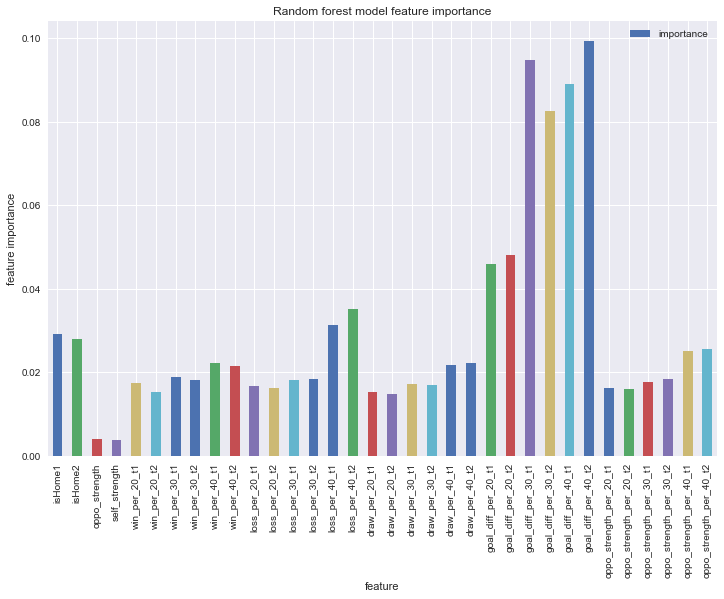

In [0]:
feature_importance = pd.DataFrame(X_test.columns, columns=['feature'])
feature_importance['importance'] = gs.best_estimator_.feature_importances_
feature_importance.plot.bar('feature','importance')
plt.ylabel("feature importance")
plt.title("Random forest model feature importance")
plt.show()

* Feature importance, 有时称为"gini importance"或"mean decrease impurity", 定义为特征节点在整个随机森林中，在每颗树上贡献的所有impurity下降的期望值的平均。
* Feature importance is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble. 
* 较为重要的特征主要分布在goal difference，前30场胜率，主场信息等

## World Cup Simulation

对2018年俄罗斯世界杯进行模拟：
* 模拟进行10000次，输出10000次冠军结果，并保存了所有中间结果
* 为方便小组赛、淘汰赛模拟，预先准备所有32支球队两两对战的数据集，即使这场比赛不可能出现在世界杯中
* 模拟小组赛时
    * 各组以积分形式，赢球得3分，平均得1分，输球得0分
    * 小组赛前两名出线，理论上优先级按积分->小组赛中总净胜球->小组赛中总进球数->并列球队胜负关系->并列球队净胜球->并列球队进球数
    * 为简单起见，如果遇到平局则再模拟两队交战，直到分出胜负或者number of iteration达到某一阈值
* 模拟淘汰赛时
    * 胜者进入下一轮，负者被淘汰
    * 若遇到平局则再模拟两队交战，直到分出胜负或者number of iteration达到某一阈值

In [0]:
wc_groups = pd.read_csv("./world_cup/wc_groups.csv")

#### 首先，准备世界杯32支球队的所有可能的比赛，生成必要的特征，预测样本数量为496

In [0]:
# team1,team2 combinations
total_game = []
total_comb = combinations(wc_groups['name'].values,2)
for i in list(total_comb):
    total_game.append(list(i))
total_game_df = pd.DataFrame(total_game, columns=['team1','team2'])

# RUS主场
total_game_df['isHome1'] = False
total_game_df['isHome2'] = False
for i in range(len(total_game_df)):
    if total_game_df.loc[i,'team1']=='RUS':
        total_game_df.loc[i,'isHome1'] = True
    if total_game_df.loc[i,'team2']=='RUS':
        total_game_df.loc[i,'isHome2'] = True


In [0]:
# this cell should run only once
total_game_df = total_game_df.merge(team_strength, how='left', left_on='team2', right_on='fifa_code')
total_game_df = total_game_df.merge(team_strength, how='left', left_on='team1', right_on='fifa_code')
total_game_df = total_game_df.rename(columns={'strength_x':'oppo_strength', 'strength_y':'self_strength'})
total_game_df = total_game_df.drop_duplicates()
total_game_df.index = range(len(total_game_df))

In [0]:
# add all necessary variables
for i in range(len(wc_groups)):
    t1 = wc_groups.loc[i,'name']
    tmp1 = matches[matches['team1']==t1].sort_values(by='date', ascending=False)
#     tmp2 = matches[matches['team1']==t2].sort_values(by='date', ascending=False)
    tmp1.index = range(len(tmp1))
#     tmp2.index = range(len(tmp2))
    for width in [20,30,40]:
        end1 = min(len(tmp1), width)
#         end2 = min(len(tmp2), width)
        # team 1
        wc_groups.loc[i,'win_per_'+str(width)+'_t1'] = sum(tmp1['win'][:end1]) / (width + 0.0)
        wc_groups.loc[i,'loss_per_'+str(width)+'_t1'] = sum(tmp1['loss'][:end1]) / (width + 0.0)
        wc_groups.loc[i,'draw_per_'+str(width)+'_t1'] = sum(tmp1['draw'][:end1]) / (width + 0.0)
        wc_groups.loc[i,'goal_diff_per_'+str(width)+'_t1'] = sum(tmp1['goal_diff'][:end1]) / (width + 0.0)
        wc_groups.loc[i,'oppo_strength_per_'+str(width)+'_t1'] = sum(tmp1['oppo_strength'][:end1]) / (width + 0.0)
        # team 2
#         total_game_df.loc[i,'win_per_'+str(width)+'_t2'] = sum(tmp2['loss'][:end2]) / (width + 0.0)
#         total_game_df.loc[i,'loss_per_'+str(width)+'_t2'] = sum(tmp2['win'][:end2]) / (width + 0.0)
#         total_game_df.loc[i,'draw_per_'+str(width)+'_t2'] = sum(tmp2['draw'][:end2]) / (width + 0.0)
#         total_game_df.loc[i,'goal_diff_per_'+str(width)+'_t2'] = -sum(tmp2['goal_diff'][:end2]) / (width + 0.0)
#         total_game_df.loc[i,'oppo_strength_per_'+str(width)+'_t2'] = sum(tmp2['self_strength'][:end2]) / (width + 0.0)

In [0]:
total_game_df = total_game_df.merge(wc_groups, how='left', left_on='team1', right_on='name')
new_columns = []
for col in wc_groups.columns:
    tmp = col
    if '_t1' in tmp:
        tmp = tmp.replace('_t1','_t2')
    new_columns.append(tmp)
wc_groups.columns = new_columns
total_game_df = total_game_df.merge(wc_groups, how='left', left_on='team2', right_on='name')

#### 用之前已训练好的模型对未来的比赛进行预测

In [0]:
X_predict = total_game_df[feature_list]
# here we use the model we trained before to make prediction
y_result = gs.best_estimator_.predict(X_predict)
# add results mean and sd into the total game dataframe
total_game_df['result_mean'] = y_result
std_list = []
for j in range(len(X_predict)):
    res = []
    for i in range(100):
        res.append(gs.best_estimator_.estimators_[i].predict(X_predict.values[j].reshape(1,-1))[0])
    std_list.append(np.std(res))
total_game_df['result_std'] = std_list

#### 举巴西和阿根廷的例子，以解释正态模拟

In [0]:
# ground true
true = matches_2[(matches_2['team1']=='ARG') & (matches_2['team2']=='BRA')]
# true2 = matches_2[(matches_2['team2']=='ARG') & (matches_2['team1']=='BRA')]
print 'ARG VS BRA'
print 'Win: ', true['win'].sum()
print 'Loss: ', true['loss'].sum()
print 'Draw: ', true['draw'].sum()

ARG VS BRA
Win:  10
Loss:  15
Draw:  10


In [0]:
# simulation once and return goal difference
def simulation_game(team1, team2):
    simulate = total_game_df[(total_game_df['team1']==team1) & (total_game_df['team2']==team2)]
    t1,t2 = team1, team2
    if simulate.empty:
        simulate = total_game_df[(total_game_df['team2']==team1) & (total_game_df['team1']==team2)]
        t2,t1 = team1, team2
    mean = simulate['result_mean'].values[0]
    std = simulate['result_std'].values[0]
    res = round(np.random.normal(mean, std, 1))
    return t1,t2,res

simulation_game('JPN','ARG')

('ARG', 'JPN', 3.0)

#### 准备世界杯分组信息

In [0]:
group_phase = []
for group in ['A','B','C','D','E','F','G','H']:
    tmp = wc_groups[wc_groups['draw'].str.contains(group)]
    comb = combinations(tmp['name'].values,2)
    for i in list(comb):
        group_phase.append(list(i)+[group])
        
group_phase_df = pd.DataFrame(group_phase, columns=['team1','team2','group'])

In [0]:
group_phase_df.head(2)

,team1,team2,group
0,RUS,KSA,A
1,RUS,EGY,A


In [0]:
import random

def kickoff(team1, team2):
    counter = 0
    while True:
        counter += 1
        if counter >=20:
            return random.choice([team1,team2])
        t1, t2, result = simulation_game(team1, team2)
#         print t1, t2, result
        if result == 0:
            continue
        else:
            return t1 if result>0 else t2
        

def simulation():
    
    group_phase_dict = {}
    for i in range(len(group_phase_df)):
        team1 = group_phase_df.loc[i,'team1']
        team2 = group_phase_df.loc[i,'team2']
        t1, t2, result = simulation_game(team1, team2)
        if result > 0:
            s1,s2 = 3,0
        if result < 0:
            s1,s2 = 0,3
        if result == 0:
            s1,s2 = 1,1
        group_phase_df.loc[i,'group_phase_result'] = result
        if team1 not in group_phase_dict:
            group_phase_dict[t1] = [s1,result]
        else:
            group_phase_dict[t1][0] += s1
            group_phase_dict[t1][1] += result

        if team2 not in group_phase_dict:
            group_phase_dict[t2] = [s2,-result]
        else:
            group_phase_dict[t2][0] += s2
            group_phase_dict[t2][1] -= result

    # calculate group score
    for i in range(len(wc_groups)):
        team = wc_groups.loc[i,'name']
        wc_groups.loc[i,'group_phase_score'] = group_phase_dict[team][0]
        wc_groups.loc[i,'group_phase_goal'] = group_phase_dict[team][1]

    # kickoff list
    kickoff_dict = {}
    for group in ['A','B','C','D','E','F','G','H']:
        tmp = wc_groups[wc_groups['draw'].str.contains(group)].sort_values(by=['group_phase_score',
                                                                               'group_phase_goal'],ascending=False)
        kickoff_dict[group+'1'] = tmp['name'].values[0]
        kickoff_dict[group+'2'] = tmp['name'].values[1]
#     print kickoff_dict

    # 1/8
    kickoff_game_8 = [('A1','B2'),('A2','B1'),
                      ('C1','D2'),('C2','D1'),
                      ('E1','F2'),('E2','F1'),
                      ('G1','H2'),('G2','H1')]
    winner_8_list = []
    for g in kickoff_game_8:
        winner = kickoff(kickoff_dict[g[0]],kickoff_dict[g[1]])
        winner_8_list.append(winner)
#     print winner_8_list

    # 1/4
    kickoff_game_4 = [(1,3),(2,4),(5,7),(6,8)]
    winner_4_list = []
    for g in kickoff_game_4:
        winner = kickoff(winner_8_list[g[0]-1],winner_8_list[g[1]-1])
        winner_4_list.append(winner)
#     print winner_4_list

    # semi-final
    kickoff_game_2 = [(1,3),(2,4)]
    winner_2_list = []
    for g in kickoff_game_2:
        winner = kickoff(winner_4_list[g[0]-1],winner_4_list[g[1]-1])
        winner_2_list.append(winner)
#     print winner_2_list

    # final 
    champion = kickoff(winner_2_list[0],winner_2_list[1])
    
#     print champion
#     print '---------------------------------------------------'
    return champion, kickoff_dict, winner_8_list, winner_4_list, winner_2_list

#### 模拟10000次世界杯比赛

In [0]:
simulation_result = []
kickoff_16_result = []
kickoff_8_result = []
kickoff_4_result = []
kickoff_2_result = []
for _ in range(10000):
    champion, kickoff_16, kickoff_8, kickoff_4, kickoff_2 = simulation()
    simulation_result.append(champion)
    kickoff_16_result.append(kickoff_16)
    kickoff_8_result.append(kickoff_8)
    kickoff_4_result.append(kickoff_4)
    kickoff_2_result.append(kickoff_2)

### 冠军分布图

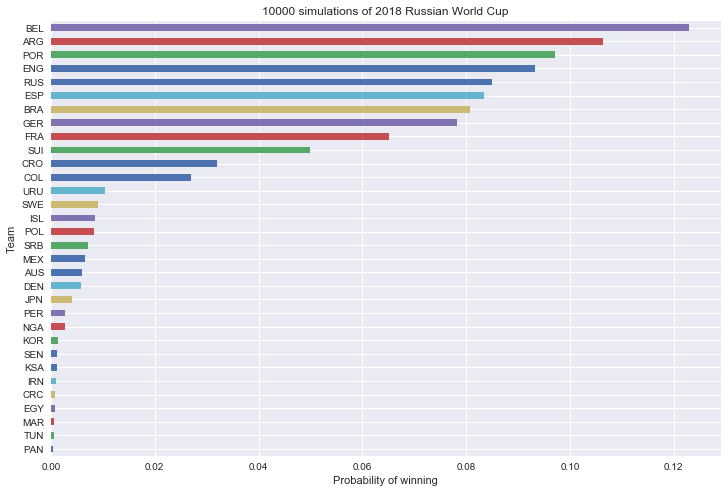

In [0]:
simulation_dict = dict(Counter(simulation_result))
simulation_df = pd.Series(simulation_dict,index=simulation_dict.keys()).sort_values()
simulation_df = simulation_df/(sum(simulation_df)+0.0)
simulation_df.plot.barh()
plt.xlabel("Probability of winning")
plt.ylabel("Team")
plt.title("10000 simulations of 2018 Russian World Cup")
plt.show()

### 小组赛出线分布图

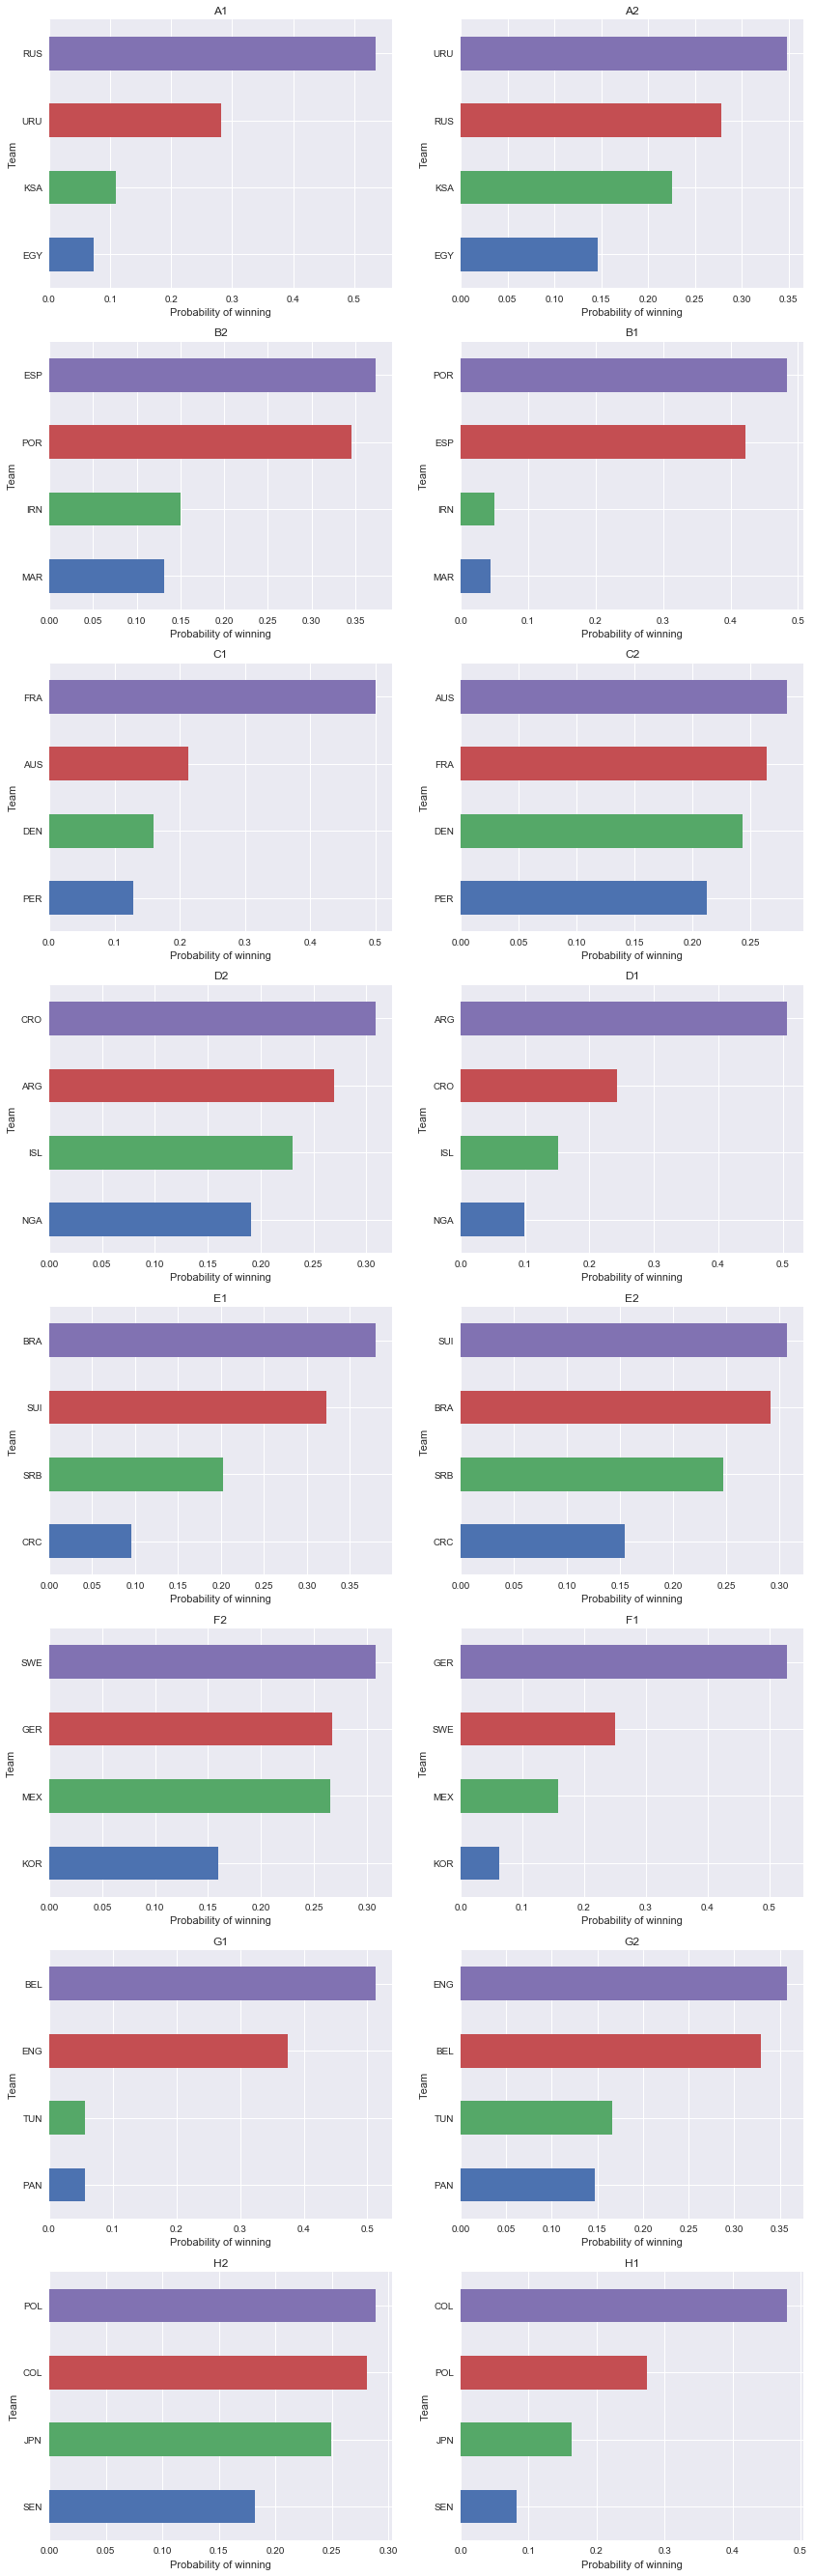

In [0]:
def plot_result(res, type_, ax):
    simulation_dict = dict(Counter(res))
    simulation_df = pd.Series(simulation_dict,index=simulation_dict.keys()).sort_values()
    simulation_df = simulation_df/(sum(simulation_df)+0.0)
    simulation_df.plot.barh(ax=ax)
    ax.set_xlabel("Probability of winning")
    ax.set_ylabel("Team")
    ax.set_title(type_)
    

kickoff_16_index = ['A1','A2','B2','B1','C1','C2','D2','D1','E1','E2','F2','F1','G1','G2','H2','H1']
fig, ax = plt.subplots(8,2,figsize=(14,48))
for i,c in enumerate(kickoff_16_index):
    tmp_list = [dic[c] for dic in kickoff_16_result]
    plot_result(tmp_list, c, ax[i/2][i%2])

In [0]:
res = []
for i in range(10000):
    res.append(simulation_game('JPN','ARG'))